# K-최근접 이웃(K-Nearst Neighbors, k-NN)
- 분류와 회귀를 모두 지원한다.
- 예측하려는 데이터와 input 데이터들 간의 거리를 측정해 가장 가까운 k개의 데이터셋의 레이블을 참조해 분류/예측한다.
- 학습시 단순히 input 데이터들을 저장만 하여 예측 시점의 거리를 계산다.
    - 학습은 빠르지만 예측시 시간이 소요됨.
- K-NN에서 

## 주요 하이퍼파라미터
- 이웃 수
    - n_neghbors = K
    - K는 새로운 데이터포인트를 분류할 때 확인할 데이터 포인트 개수를 의미한다.
    - K가 너무 작으면 과적합이 일어나고, K가 너무 크면 성능이 나빠진다.(overfitting vs underfitting)

- 거리 재는 방법
    - p=2: 유클리드 거리(Euclidean distance) - default값
    - p=1: 맨하튼 거리(Manhattan distance)

### KNN 요약
- KNN은 이해하기 쉬운 모델이며 튜닝할 하이퍼파라미터의 수가 적어 빠르게 만들 수 있다.
- KNN은 서비스할 모델을 구현할때 보다는 복잡한 알고리즘을 적용해 보기 전에 확인용 또는 base line을 잡기 위한 모델로 사용
- 훈련세트가 너무 큰 경우(Feature나 관측치의 개수가 많은 경우) 거리를 계산하는 양이 늘어나 예측이 느려진다.
- Feature 간 값의 단위가 다르면 작은 단위의 Feature에 영향을 많이 받게 됨으로 전처리로 Scaling 작업이 필요
- Feature가 너무 많은 경우와 대부분의 값이 0으로 구성된(희소-sparse) 데이터셋에서 성능이 아주 나쁘다.

---
---

## 실습 : 위스콘신 유방암 데이터를 이용한 암환자분류
- malignant : 악성
- benign : 양성

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.3, stratify=cancer.target)

In [2]:
# 스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### KNN 모델 fitting

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_param = range(1,11)
train_acc_list = []
test_acc_list = []

for k in k_param:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    knn.fit(X_train_scaled, y_train)
    
    pred_train = knn.predict(X_train_scaled)
    pred_test = knn.predict(X_test_scaled)
    
    train_acc_list.append(accuracy_score(y_train,pred_train))
    test_acc_list.append(accuracy_score(y_test,pred_test))

In [17]:
dic = {
    'k':k_param,
    'Train accuracy':train_acc_list,
    'Test accuracy':test_acc_list
}
acc_df = pd.DataFrame(dic)
acc_df

,k,Train accuracy,Test accuracy
0,1,1.000000,0.964912
1,2,0.974874,0.959064
2,3,0.979899,0.964912
3,4,0.974874,0.970760
4,5,0.962312,0.959064
5,6,0.962312,0.970760
6,7,0.959799,0.976608
7,8,0.959799,0.970760
8,9,0.969849,0.976608
9,10,0.969849,0.970760


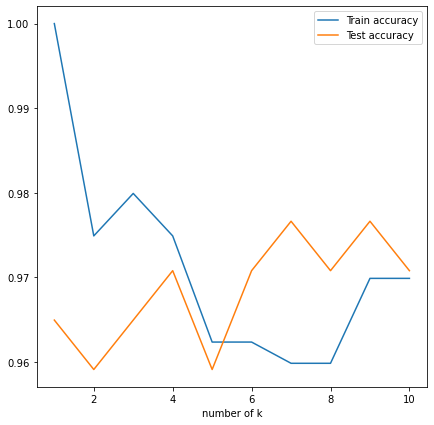

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

acc_df2 = acc_df.set_index('k')
acc_df2 = acc_df2.sort_index(ascending=False)

acc_df2.plot(figsize=(7,7))
plt.xlabel('number of k')
plt.show()

### GridSearchCV로 최적의 파라미터 찾기

In [19]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

n_neighbors = range(1,11)
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = [1, 2, 3, 4, 5, 10]

hyperparams = {'algorithm': algorithm, 
               'weights': weights, 
               'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}

gs = GridSearchCV(estimator = knn, param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy", n_jobs=-1)

In [23]:
gs.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto'],
                         'leaf_size': [1, 2, 3, 4, 5, 10],
                         'n_neighbors': range(1, 11),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=True)

In [24]:
print('GridSearchCV 최적 파라미터:',gs.best_params_)
print('GridSearchCV 최고 정확도:',gs.best_score_)
print('GridSearchCV 최고성능 모델:',gs.best_estimator_)

GridSearchCV 최적 파라미터: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 9, 'weights': 'distance'}
GridSearchCV 최고 정확도: 0.9596518987341772
GridSearchCV 최고성능 모델: KNeighborsClassifier(leaf_size=1, n_neighbors=9, weights='distance')


In [27]:
best_model = gs.best_estimator_

best_model.fit(X_train_scaled, y_train)

pred_train = best_model.predict(X_train_scaled)
pred_test = best_model.predict(X_test_scaled)

print("train accuracy:",accuracy_score(y_train,pred_train))
print("test accuracy:",accuracy_score(y_test,pred_test))

# 이것도 같은 결과이다.
print("test accuracy:", accuracy_score(y_test,gs.predict(X_test_scaled)))

train accuracy: 1.0
test accuracy: 0.9766081871345029
test accuracy: 0.9766081871345029
